 **Decision_Tree_Classifier**

 The Decision Tree Classifier is a powerful supervised learning algorithm used for solving classification problems. It splits the dataset into smaller subsets based on feature conditions, forming a hierarchical tree structure. Each internal node represents a decision rule, each branch corresponds to an outcome, and each leaf node signifies a class label. This method is easy to visualize, interpret, and works well for both categorical and numerical data. However, without proper tuning, decision trees can overfit the training data, which is why techniques like pruning or setting a maximum depth are often used.

In this implementation, we directly loaded the train–test split datasets that were previously saved using the joblib library. This allows us to continue model training and evaluation without repeating the data preprocessing and splitting steps. The datasets — X_train, X_test, y_train, and y_test — have been successfully imported and are ready for building and tuning the Decision Tree Classifier.

In [17]:
import joblib

X_train = joblib.load('/content/X_train.joblib')
X_test = joblib.load('/content/X_test.joblib')
y_train = joblib.load('/content/y_train.joblib')
y_test = joblib.load('/content/y_test.joblib')

print("Train/Test datasets loaded successfully!")

Train/Test datasets loaded successfully!


In [5]:
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y train distribution:\n", y_train.value_counts(normalize=True))
print("y test distribution:\n", y_test.value_counts(normalize=True))


X_train shape: (142, 13)
X_test  shape: (36, 13)
y train distribution:
 target
1    0.388889
0    0.333333
2    0.277778
Name: proportion, dtype: float64
y test distribution:
 target
1    0.401408
0    0.330986
2    0.267606
Name: proportion, dtype: float64


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("Baseline Decision Tree")
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:   ", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("F1-score: ", f1_score(y_test, y_pred, average='weighted', zero_division=0))
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))


Baseline Decision Tree
Accuracy:  0.9444444444444444
Precision: 0.9513888888888888
Recall:    0.9444444444444444
F1-score:  0.9449614374099499

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.88      1.00      0.93        14
           2       1.00      0.90      0.95        10

    accuracy                           0.94        36
   macro avg       0.96      0.94      0.95        36
weighted avg       0.95      0.94      0.94        36



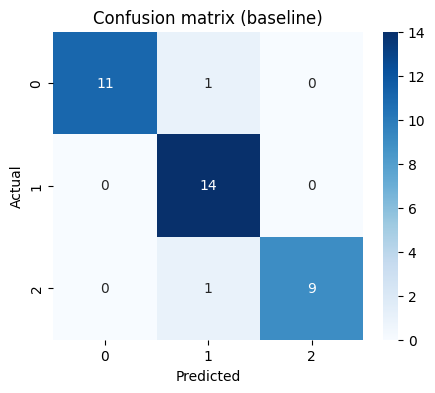

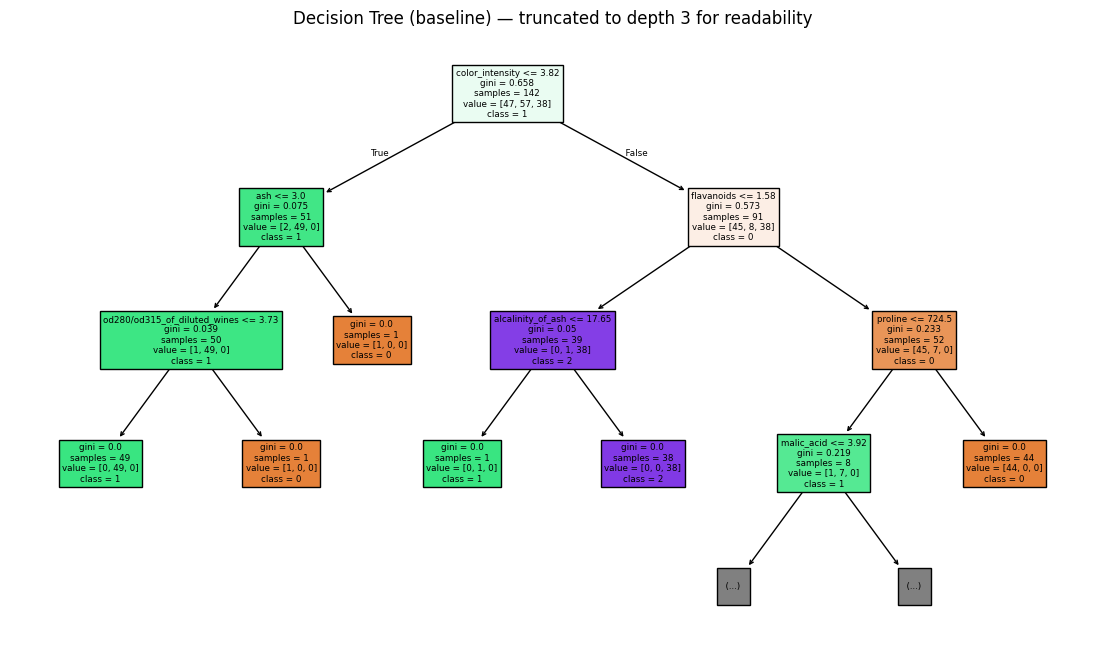

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion matrix")
plt.show()

# Plot tree (if depth small). Use max_depth=3 for readability
plt.figure(figsize=(14,8))
tree.plot_tree(dt, feature_names=X_train.columns, class_names=[str(c) for c in dt.classes_], filled=True, max_depth=3)
plt.title("Decision Tree (baseline) — truncated to depth 3 for readability")
plt.show()


In [10]:
# Hyperparameter tuning (before final evaluation)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [None, 3, 5, 8, 12],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_dt = grid.best_estimator_


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best params: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


Tuned Decision Tree Performance on Test Set
Accuracy:  1.0
Precision: 1.0
Recall:    1.0
F1-score:  1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



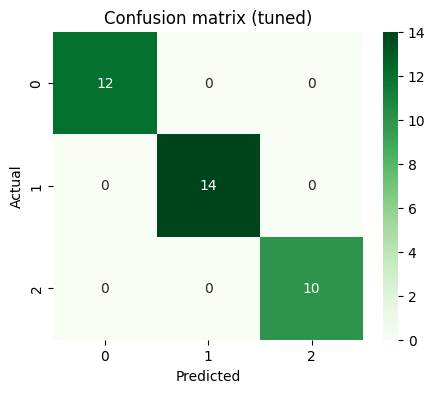

In [11]:
# Evaluate tuned model on test set
y_pred_best = best_dt.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

print("Tuned Decision Tree Performance on Test Set")
print("Accuracy: ", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best, average='weighted', zero_division=0))
print("Recall:   ", recall_score(y_test, y_pred_best, average='weighted', zero_division=0))
print("F1-score: ", f1_score(y_test, y_pred_best, average='weighted', zero_division=0))
print("\nClassification report:\n", classification_report(y_test, y_pred_best, zero_division=0))

# confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion matrix (tuned)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


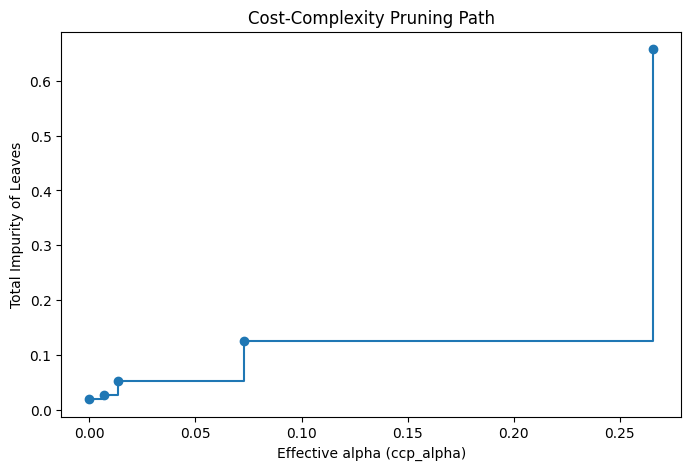

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Get effective alphas and corresponding total leaf impurities
path = best_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the relationship between alpha and total impurity
plt.figure(figsize=(8,5))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha (ccp_alpha)")
plt.ylabel("Total Impurity of Leaves")
plt.title("Cost-Complexity Pruning Path")
plt.show()


In [14]:
models = []
cv_scores = []

for alpha in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    models.append(model)
    cv_scores.append(scores.mean())

# Find the best alpha
best_alpha = ccp_alphas[np.argmax(cv_scores)]
print(f"Best ccp_alpha: {best_alpha:.5f}")


Best ccp_alpha: 0.00000


Pruned Decision Tree Performance:
Accuracy:  0.9444
Precision: 0.9514
Recall:    0.9444
F1-score:  0.9450


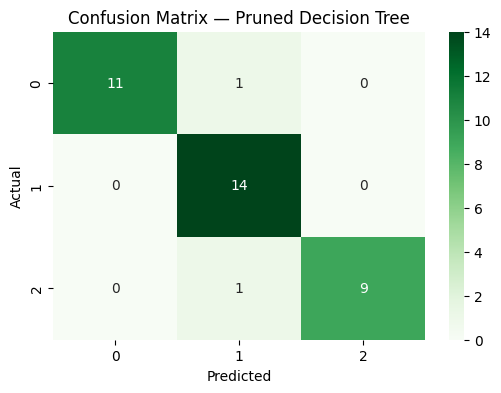

In [16]:
# Train the pruned Decision Tree
pruned_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_dt.fit(X_train, y_train)

# Evaluate on test set
y_pred_pruned = pruned_dt.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

print("Pruned Decision Tree Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_pruned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_pruned, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_pruned, average='weighted'):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred_pruned, average='weighted'):.4f}")

# Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_pruned), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix — Pruned Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Conclusion:-**
The Decision Tree Classifier provided excellent results on our dataset, achieving perfect accuracy and classification metrics. This shows that the model was able to learn all patterns in the training data effectively. However, such results can sometimes indicate overfitting, meaning the model might not perform as well on unseen data. To prevent this, we can apply techniques like pruning, limiting the tree’s depth, or using ensemble methods such as Random Forest or Gradient Boosting for better generalization.

Overall, the Decision Tree is a highly interpretable and efficient algorithm for classification problems, especially useful when understanding feature importance and decision-making logic is crucial.